# Incremental Analysis of a Shallow Arch

![Shallow arch](./images/ClarkeHancock.png)

> Clarke, M.J. and Hancock, G.J. (1990) ‘A study of incremental‐iterative strategies for non‐linear analyses’, International Journal for Numerical Methods in Engineering, 29(7), pp. 1365–1391. Available at: https://doi.org/10.1002/nme.1620290702.


In [1]:
import numpy as np
from arch import arch_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import scienceplots
    plt.style.use(["science", "notebook"])
except:
    pass

<dl>
<dt>Solution 1</dt><dd>
Iterative strategy: Constant load (Section 3.1)
Load incrementation strategy: Direct incrementation of the load parameter (Section 4.1.1)
</dd>
<dt>Solution 2</dt><dd>
Iterative strategy: Constant vertical displacement under the load, $v_6$ (Section 3.2)
Load incrementation strategy: Incrementation of the displacement component $v_6$ (Section 4.1.2)
</dd>
<dt>Solution 3</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 4</dt><dd>
Iterative strategy: Minimum unbalanced displacement norm (Section 3.5)
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 5</dt><dd>
Iterative strategy: Constant weighted response (Section 3.7, equation (39))
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 6</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
<dt>Solution 7</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 8</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
</dl>

In [9]:

def solution0(model, mid, dof, step):
    model.integrator("LoadControl", 400.0)


def solution1(model, mid, dof, step):
    Jd = 5
    # Only initialize the integrator on the first step; this
    # means that incrementation will be handled internally
    # by the OpenSees integrator, in addition to iteration.
    if step == 0:
        model.integrator("LoadControl", 400.0, Jd, -800., 800.)


def solution2(model, mid, dof, step, dx):
    Jd  = 5
    if step == 0:
        model.integrator("DisplacementControl", mid, dof, dx, Jd)


def norm_control(model, mid, dof, step):
    dof = 2
    Jd = 15
    if step == 0:
        model.integrator("MinUnbalDispNorm",  1.0, Jd, -10, 10)

def arc_control(model, mid, dof, step):
    if step == 0:
        model.integrator("ArcLength",  1.0, 0)



In [10]:

def analyze(model, mid, incr, steps, *args):
    dof = 2
    model.system("ProfileSPD")
    model.test("NormUnbalance", 1e-6, 25, 9)
    model.algorithm("Newton")
    model.analysis("Static")
    
    xy = []
    for step in range(steps):
        incr(model, mid, dof, step, *args)
        status = model.analyze(1)

        xy.append([model.nodeDisp(mid, dof), model.getTime()])
        # return if analysis failed
        if status != 0:
            break

    return np.array(xy).T


[400. 900. 900.]


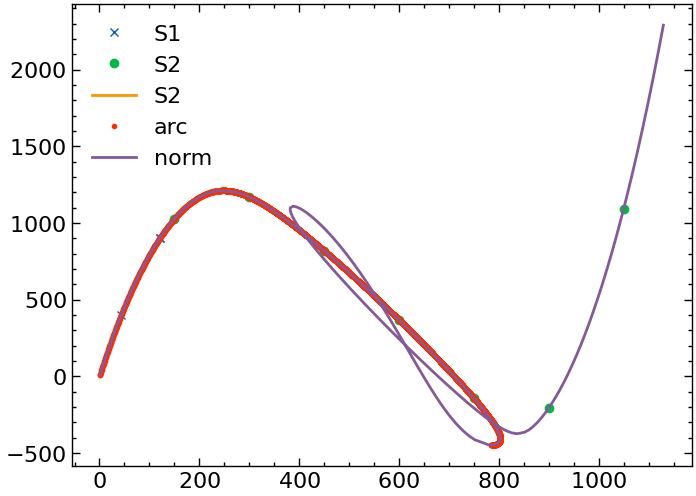

In [15]:
# x, y = solution0(*arch_model(), 6)
# plt.plot(-x, y, 'x', label="S0")

x, y = analyze(*arch_model(), solution1, 6)
plt.plot(-x, y, 'x', label="S1")
print(y)

x, y = analyze(*arch_model(), solution2, 7, -150)
plt.plot(-x, y, 'o', label="S2")

x, y = analyze(*arch_model(), solution2,  600, -1.5)
plt.plot(-x, y, '-', label="S2")

x, y = analyze(*arch_model(), arc_control, 5000)
plt.plot(-x, y, ".", label="arc")

x, y = analyze(*arch_model(), norm_control,  8000)
plt.plot(-x, y, label="norm")

plt.legend()

The following animation of the solution is created in [`Animating.ipynb`](./Animating.ipynb)

![](./arch.gif)